In [1]:
import wfdb
import os
def parse_annotation_file(atr_file_path):
    """
    Parse the annotations from a .atr file.

    Parameters:
    - atr_file_path (str): Path to the .atr file.

    Returns:
    - annotations (list): List of annotations.
    """
    # Use the `rdann` function from the wfdb library to read annotations
    annotation = wfdb.rdann(atr_file_path,extension="atr")

    # Extract the sample numbers and symbols from the annotation
    sample_numbers = annotation.sample
    symbols = annotation.symbol

    # Combine sample numbers and symbols into a list of tuples
    annotations = list(zip(sample_numbers, symbols))

    return sample_numbers

In [2]:
atrr=parse_annotation_file(r'C:\Users\Priyanshu\Desktop\Dataset\files\04015')
print(atrr)

[     30  102584  119604  121773  122194  133348  166857 1096245 1098054
 1135296 1139595 1422436 1423548 1459277 1460416]


In [3]:
# Convert the list of ranges into a list of tuples
ranges_tuples = [(atrr[i-1], atrr[i]) for i in range(1, len(atrr))]

print(ranges_tuples)

[(30, 102584), (102584, 119604), (119604, 121773), (121773, 122194), (122194, 133348), (133348, 166857), (166857, 1096245), (1096245, 1098054), (1098054, 1135296), (1135296, 1139595), (1139595, 1422436), (1422436, 1423548), (1423548, 1459277), (1459277, 1460416)]


In [4]:
import pandas as pd
# Read the ECG data from the CSV file
ecg_data = pd.read_csv(r'C:\Users\Priyanshu\Desktop\Dataset\csv_afib\04015.csv')

# Initialize 'y' column with 0s
ecg_data['y'] = 0

# Iterate over each range and mark alternating segments as 1 in the 'y' column
for i, (start, end) in enumerate(ranges_tuples):
    if i % 2 == 0:
        ecg_data.loc[start:end, 'y'] = 1

# Printing the updated DataFrame
print(ecg_data.iloc[68:100])


     ECG1   ECG2  y
68 -0.440 -0.470  1
69 -0.435 -0.380  1
70 -0.440 -0.320  1
71 -0.430 -0.310  1
72 -0.425 -0.320  1
73 -0.410 -0.320  1
74 -0.390 -0.280  1
75 -0.415 -0.250  1
76 -0.425 -0.250  1
77 -0.405 -0.260  1
78 -0.445 -0.270  1
79 -0.445 -0.275  1
80 -0.455 -0.270  1
81 -0.460 -0.260  1
82 -0.465 -0.265  1
83 -0.475 -0.270  1
84 -0.455 -0.240  1
85 -0.430 -0.235  1
86 -0.450 -0.250  1
87 -0.470 -0.255  1
88 -0.450 -0.250  1
89 -0.460 -0.210  1
90 -0.500 -0.210  1
91 -0.500 -0.255  1
92 -0.510 -0.230  1
93 -0.505 -0.240  1
94 -0.520 -0.265  1
95 -0.500 -0.275  1
96 -0.520 -0.240  1
97 -0.525 -0.255  1
98 -0.530 -0.260  1
99 -0.560 -0.285  1


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


In [6]:
# Separate features and target variable
X = ecg_data.drop(columns=['y'])  # Make sure to replace 'target_column_name' with the appropriate column name for your target variable
y = ecg_data['y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [7]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10600     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                

In [8]:
history=model.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test))



115072/115072 [==============================] - 671s 6ms/step - loss: 0.4232 - accuracy: 0.8481 - val_loss: 0.4226 - val_accuracy: 0.8478


In [10]:
# Assuming 'history' contains your trained model
model.save("my_model.h5")

C:\Users\Priyanshu\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10


115072/115072 [==============================] - 917s 8ms/step - loss: 0.4232 - accuracy: 0.8481 - val_loss: 0.4227 - val_accuracy: 0.8479
Epoch 2/10
115072/115072 [==============================] - 922s 8ms/step - loss: 0.4220 - accuracy: 0.8482 - val_loss: 0.4222 - val_accuracy: 0.8480
Epoch 3/10
115072/115072 [==============================] - 923s 8ms/step - loss: 0.4218 - accuracy: 0.8482 - val_loss: 0.4222 - val_accuracy: 0.8479
Epoch 4/10
115072/115072 [==============================] - 709s 6ms/step - loss: 0.4217 - accuracy: 0.8482 - val_loss: 0.4221 - val_accuracy: 0.8479
Epoch 5/10
115072/115072 [==============================] - 823s 7ms/step - loss: 0.4216 - accuracy: 0.8482 - val_loss: 0.4221 - val_accuracy: 0.8479
Epoch 6/10
115072/115072 [==============================] - 767s 7ms/step - loss: 0.4215 - accuracy: 0.8482 - val_loss: 0.4220 - val_accuracy: 0.8480
Epoch 7/10
115072/115072 [==============================] - 630s 5ms/step - loss: 0.4215 - accurac

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
# from tensorflow.keras.models import load_model

# # Load the model
# model = load_model("my_model.h5")


# Compute loss and accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (y_pred_probs > 0.5).astype(int)

# Convert predictions to 1D array
y_pred = y_pred.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# True negatives, false positives, false negatives, true positives
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate sensitivity (or recall)
sensitivity = tp / (tp + fn)

# Print specificity and sensitivity
print("Specificity:", specificity)
print("confusion matrix",conf_matrix)
# print("Sensitivity:", sensitivity)

# Print classification report with zero_division parameter set to 1
print(classification_report(y_test, y_pred, zero_division=1))


57536/57536 [==============================] - 143s 2ms/step - loss: 0.4218 - accuracy: 0.8480
Accuracy: 0.8480261564254761
57536/57536 [==============================] - 130s 2ms/step
Specificity: 0.999361703763897
confusion matrix [[1559408     996]
 [ 278811    1937]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92   1560404
           1       0.66      0.01      0.01    280748

    accuracy                           0.85   1841152
   macro avg       0.75      0.50      0.47   1841152
weighted avg       0.82      0.85      0.78   1841152



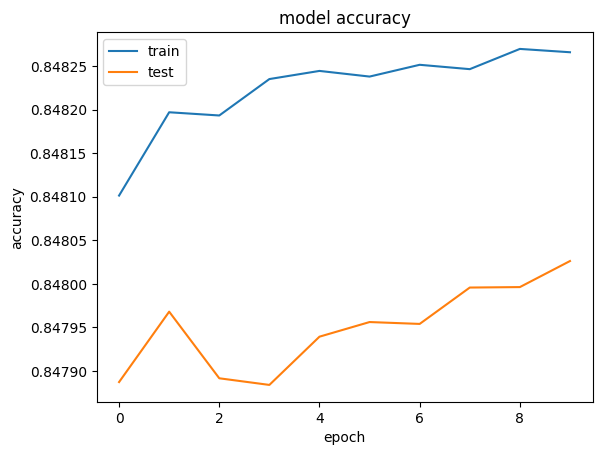

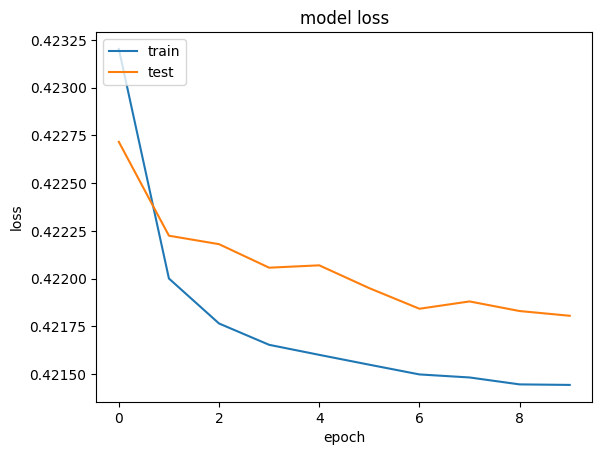

In [10]:
import matplotlib.pyplot as plt
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Accuracy AFib.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Loss AFib.png')
plt.show()